# Significant Wave Height at Bilbao Buoy 

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

os.chdir("C:/Users/user/Victor/Trabajo/ExtremeCorrection/")
sys.path.append(os.path.abspath('C:/Users/user/Victor/Trabajo/ExtremeCorrection/src'))

Load the data

In [2]:
bilbao_buoy_data = np.loadtxt("Data/Bilbao/matriz_13_Boya.txt")

In [3]:
bilbao_buoy_data = bilbao_buoy_data[:,:5]

In [4]:
df_hs = pd.DataFrame({
    "yyyy": bilbao_buoy_data[:,0].astype(np.int64),
    "mm": bilbao_buoy_data[:,1].astype(np.int64),
    "dd": bilbao_buoy_data[:,2].astype(np.int64),
    "hh": bilbao_buoy_data[:,3].astype(np.int64),
    "Hs": bilbao_buoy_data[:,4].astype(np.float64),
    })

In [5]:
df_hs.head()

,yyyy,mm,dd,hh,Hs
0,1985,2,21,9,1.3
1,1985,2,22,9,1.0
2,1985,2,22,12,0.9
3,1985,2,22,15,1.0
4,1985,2,22,18,0.9


## Generate the simulated data with an ARMA

In [6]:
from src.arma_sim import ArmaSimulation

arma = ArmaSimulation(df_hs, var='Hs', freq=365.25*24, arma_order=(1,0,1), distribution="ecdf", n_components=4)
ny_sim = 100
hs_sim = arma.generate_sim(ny_sim = ny_sim)   # We select the number of years of simulations

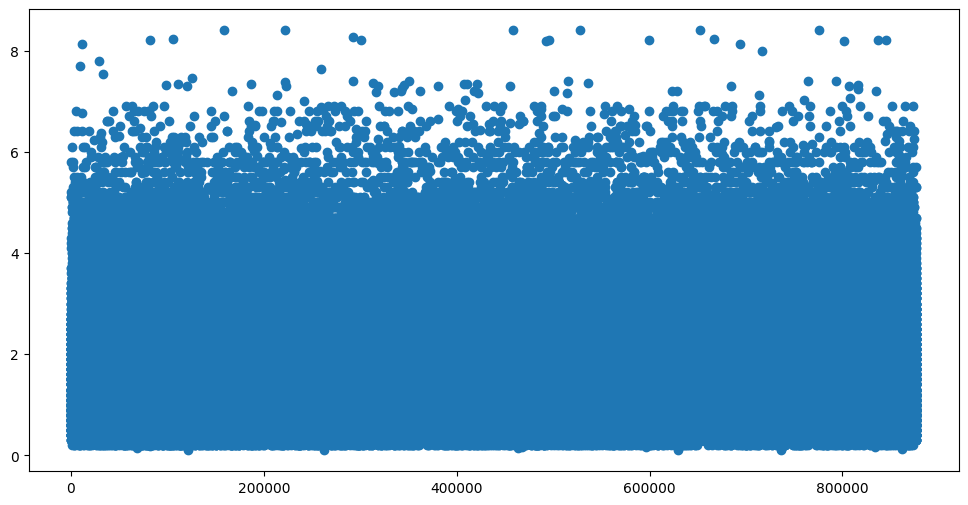

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(0,int(ny_sim*24*365.25)), hs_sim)
plt.show()

In [8]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
date_range = pd.date_range(start=start_date, periods=int(365.25*24*100), freq='h')  

In [9]:
sim_yyyy = date_range.year
sim_mm = date_range.month
sim_dd = date_range.day
sim_hh = date_range.hour

In [10]:
year_simulated = np.array([], dtype=np.int32)
month_simulated = np.array([], dtype=np.int32)
day_simulated = np.array([], dtype=np.int32)
hour_simulated = np.array([], dtype=np.int32)
for i in range(len(hs_sim)//len(date_range)):
    year_simulated = np.concatenate([year_simulated, date_range.year + 100*i])
    month_simulated = np.concatenate([month_simulated, date_range.month])
    day_simulated = np.concatenate([day_simulated, date_range.day])
    hour_simulated = np.concatenate([hour_simulated, date_range.hour])

In [11]:
df_sim = pd.DataFrame({
    'yyyy': year_simulated,
    'mm':  month_simulated,
    'dd': day_simulated,
    'hh': hour_simulated,
    'Hs': hs_sim
})

In [12]:
df_sim

,yyyy,mm,dd,hh,Hs
0,2000,1,1,0,1.6
1,2000,1,1,1,1.3
2,2000,1,1,2,0.9
3,2000,1,1,3,0.9
4,2000,1,1,4,1.9
...,...,...,...,...,...
876595,2099,12,31,19,2.3
876596,2099,12,31,20,4.0
876597,2099,12,31,21,1.6
876598,2099,12,31,22,0.7


Save simulated data

In [13]:
df_sim.to_csv("Data/Bilbao/Boya_Bilbao_sim_ecdf_POT.csv")

## Correction

In [14]:
from src.gpd_extremecorrection import GPD_ExtremeCorrection

In [15]:
config = {
    'var': 'Hs',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 24*365.25,
    'folder': 'Figures/Hs_Bilbao_ecdf_POT'
}

Initialize the correction

In [16]:
extr_corr = GPD_ExtremeCorrection(
    data = df_hs,
    config = config,
    conf = 0.95
)

### Apply historical correction

In [17]:
extr_corr.apply_correction(fit_diag=True)   # fit_diag = True, to plot the diagnostics plots (QQ-Plot and PP-plot)
extr_corr.return_period_plot()              # Default to plot only the no corrected data 

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\gpd_extremecorrection.py:238: RuntimeWarning: invalid value encountered in sqrt
  stdDq_gpd = np.sqrt(np.sum((dqgpd.T@invI0_gpd) * dqgpd.T, axis=1))


In [22]:
extr_corr.opt_threshold, extr_corr.gpd_parameters    # shape parameter is positive, and the location parameter has to be considered 0 since the threshold is applied manually

(1.3, [0, 1.0700525856675946, -0.12053593801367363])

### Apply simulated correction

In [19]:
extr_corr.apply_correction_sim(simulated_data = df_sim)   # Apply the correction in the simulated data

In [20]:
print("Historical Poisson Parameter: ", extr_corr.poiss_parameter)
print("Simulated Poisson Parameter: ", extr_corr.sim_poiss_parameter)

Historical Poisson Parameter:  509.16
Simulated Poisson Parameter:  1570.51


In [21]:
extr_corr.sim_return_period_plot()                        # Default to plot the corrected and no corrected data
extr_corr.interval_sim_return_period_plot()               # Comparative of no corrected vs corrected simulated data in the historical range
extr_corr.time_series_plot(sim=False)                     # Time series of both corrected and no-corrected data

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\gpd_extremecorrection.py:491: RuntimeWarning: invalid value encountered in sqrt
  stdDq_gpd_sim = np.sqrt(np.sum((dqgpd_sim.T@invI0_gpd_sim) * dqgpd_sim.T, axis=1)) # Es lo mismo


Dataframe with the corrected simulation

In [52]:
new_sim_data = extr_corr.sim_pit_data_corrected
new_df_sim = df_sim.copy()
new_df_sim['Hs'] = new_sim_data

In [ ]:
new_df_sim.to_csv("Data/Bilbao/Boya_Bilbao_sim_ecdf_corrected_POT.csv")